# Recommender Systems

## Contents

*   [Before we start](#before-we-start)
*   [Introduction](#introduction)
*   [Data](#data)
*   [Matrix representation](#matrix)
*   [Collaborative filtering](#collaborative-filtering)
    *   [Euclidian distance](#euclidian-distance)
    *   [Cosine similarity](#cosine-similarity)
    *   [Prediction](#prediction)
    *   [Using Surprise](#surprise)
*   [SVD](#svd)

## Before we start<a id="before-we-start"></a>

We will use [Pandas](https://pandas.pydata.org/), [Scikit-learn](https://scikit-learn.org/), [Surprise](https://surpriselib.com/), [NumPy](https://numpy.org/), and [SciPy](https://scipy.org/) in this notebook. Surprise is a Python toolkit that can be used to quickly create small-scale recommender systems. Its documentation can be found [here](https://surprise.readthedocs.io/en/stable/index.html).

## Introduction<a id="introduction"></a>

Recommender systems are everywhere today. We use them to find movies to watch, articles to read, items to buy, and people to follow. Different kinds of recommender systems use different filtering methods. A common classification is as follows:
*   Content-based filtering: These systems allow us to filter contents based on some metadata. For example, filtering movies based on genre is a content-based filtering.
*   Collaborative filtering: These systems measure a recommended item's relevance by using the user's or the item's data in collaboration with other users' or items' data.
    *   Model-based: With this approach, the system uses a trained model to predict the relevance of an item for a person.
    *   Memory-based: With this approach, the system directly uses data of the users or items to come up with recommendations. This is more straightforward than a model-based approach, but it is more memory-intensive.
        *   User-based: Recommendations are made using the user's similarity to other users. If we want to predict someone's rating for a movie, we look at people who are similar to this user, and use their rating for that movie. 
        *   Item-based: Recommendations are made using the item's similarity to other items. If we want to predict someone's rating for a movie, we look at other movies that are similar to that movie and use that person's rating for those movies. 
*   Hybrid filtering: These systems combine content-based and collaborative filtering, which usually is the case in real-life systems. We can specify a genre we want to watch, and thousands of movies from that genre can be served in an order defined by collaborative filtering methods.

In this notebook, we will explore model-based and memory-based approaches.

## Data<a id="data"></a>

We will use a preprocessed sample from [a Netflix recommendation dataset](https://www.kaggle.com/netflix-inc/netflix-prize-data). Two files are provided with this notebook. One of them is a movie dataset that includes the ID, release date, and title of movies. One problem is the title column is not quoted, so commas in titles cause issues during import. To solve this, we will use Python's CSV reader, split lines using commas, and limit the number of splits for a line to two. This way, commas that come after the last real separator are ignored. We will then create a DataFrame object from these split lines:

In [1]:
import pandas as pd

with open("movies_dataset.csv", "r", newline="\n") as file:
    movies = [line.split(",", 2) for line in file.read().splitlines()]
    movies = pd.DataFrame(movies, columns=["ID", "Year", "Title"]) # Creating a DataFrame
    movies = movies.astype({"ID": int}) # Converting IDs to integers
    
movies

,ID,Year,Title
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17764,17766,2002,Where the Wild Things Are and Other Maurice Se...
17765,17767,2004,Fidel Castro: American Experience
17766,17768,2000,Epoch
17767,17769,2003,The Company


The other file includes user ratings for each film. Each user has rated at least 300 movies.

In [2]:
ratings = pd.read_csv("ratings_dataset.csv")
ratings["Date"] = pd.to_datetime(ratings["Date"]) # We might want to deal with dates

ratings

,Movie ID,User ID,Rating,Date
0,1,1488844,3,2005-09-06
1,1,30878,4,2005-12-26
2,1,1248029,3,2004-04-22
3,1,1080361,3,2005-03-28
4,1,558634,4,2004-12-14
...,...,...,...,...
2956128,4499,811530,4,2004-07-28
2956129,4499,1852040,1,2004-05-13
2956130,4499,303969,2,2004-05-23
2956131,4499,654591,3,2004-04-26


In [3]:
print(len(ratings["Movie ID"].unique()), "unique movies")
print(len(ratings["User ID"].unique()), "unique users")

4499 unique movies
7086 unique users


While our movies dataset has 17769 movies, our rating dataset has 4499 unique movies and 7086 unique users. Looking at the number of movies users rated, we obtain a Zipfian distribution:

<AxesSubplot:ylabel='Density'>

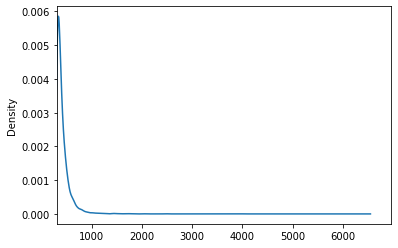

In [4]:
ratings.groupby("User ID").size().plot.density(xlim=[300,None])

## Matrix representation<a id="matrix"></a>

We can represent these ratings as a matrix of user-movie pairs. To convert the rating dataset into a matrix, we can use the `pivot_table` method with a DataFrame object. We want each row to represent a user and each column to represent a movie, so:

In [5]:
rating_matrix = ratings.pivot_table(index="User ID", columns="Movie ID", values="Rating")

rating_matrix

Movie ID,1,2,3,4,5,6,7,8,9,10,...,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499
User ID,,,,,,,,,,,,,,,,,,,,,
1333,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2787,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3321,3.0,NaN,NaN,NaN,4.0,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646634,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2647197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2647888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Since most people rate only a fraction of the possible items, these matrices are commonly sparse, especially in real-life scenarios.

We should be careful that row/column indices are not the same with IDs. For example, the first row represents User 1333. If we want to access a user using their ID, we need to use `loc`. If we want to access a user using their index among all users, we need to use `iloc`.

This retrieves the first row's third column:

In [6]:
rating_matrix.iloc[0,2]

4.0

This retrieves User 1333's rating for Movie 3 (which corresponds to the same thing as above):

In [7]:
rating_matrix.loc[1333,3]

4.0

We may want to have a conversion method between indices and IDs for users and movies. For this reason, we can create some conversion dictionaries:

In [8]:
user_id_to_index = {user_id: index for index, user_id in enumerate(rating_matrix.index)}
user_index_to_id = {index: user_id for user_id, index in user_id_to_index.items()} # Reversed

movie_id_to_index = {movie_id: index for index, movie_id in enumerate(rating_matrix.columns)}
movie_index_to_id = {index: movie_id for movie_id, index in movie_id_to_index.items()} # Reversed

user_id_to_index[1333]
# user_index_to_id[0]

0

## Collaborative filtering<a id="collaborative-filtering"></a>

### Euclidian distance<a id="euclidian-distance"></a>

Consider these three users, four movies, and their ratings:
    
<table>
    <tr>
        <td></td>
        <td><b>Movie 1</b></td>
        <td><b>Movie 2</b></td>
        <td><b>Movie 3</b></td>
        <td><b>Movie 4</b></td>
    </tr>
    <tr>
        <td><b>User 1</b></td>
        <td>1</td>
        <td>4</td>
        <td>4</td>
        <td style="color: red;">?</td>
    </tr>
    <tr>
        <td><b>User 2</b></td>
        <td>2</td>
        <td>3</td>
        <td>4</td>
        <td>5</td>
    </tr>
    <tr>
        <td><b>User 3</b></td>
        <td>4</td>
        <td>2</td>
        <td>1</td>
        <td>1</td>
    </tr>
</table>

Assume that we want to predict User 1's rating for Movie 3. How can we make use of the other users' ratings? User 2 has rated Movie 3 as 5 while User 3 has rated it as 1. What could be User 1's rating for this movie?

Intuitively, we can say that User 1's rating would probably be closer to 5 rather than 1 because User 1 has more similar ratings with User 2 than with User 3. We can measure this similarity by calculating the **Euclidian distance** between User 1 and the other users using the jointly rated movies:

$distance(User\;1, User\;2) =  \sqrt{(1-2)^2 + (4-3)^2 + (4-4)^2} \approx 1.41$

$distance(User\;1, User\;2) =  \sqrt{(1-4)^2 + (4-2)^2 + (4-1)^2} \approx 4.69 $

User 2 is indeed closer as their distance is much smaller. However, this distance metric is harder to interpret. The moment we add a new movie or change the rating scale, distances change without an upper bound, which makes it harder to compare distances before and after changes. For this reason, we prefer to use cosine similarity.

### Cosine similarity<a id="cosine-similarity"></a>

In linear algebra, we compare two non-zero vectors' similarity by looking at the angle between them. If two normalized vectors are the same, their angle is 0 degrees. If they are the exact opposites, they are orthogonal, so they are 90 degrees apart. Cosine similarity is based on the cosine of their angle. Since cosine can take a value between cos(0) = 0 and cos(90) = 1, we can easily interpret two vectors' similarities using the cosine similarity. A cosine similarity of 0.9 suggests a 90% similarity between the two vectors.

If we do not know the angle itself, we can calculate the **cosine similarity** as follows:

$similarity(A, B) = \dfrac{A \cdot B}{||A|| \times ||B||}$

This calculates the dot product of two vectors and divides it by the multiplication of their magnitudes (lengths), which normalizes the vectors in the process.

The **dot product** of two vectors are calculated as follows:

$A \cdot B = a_1 b_1 + a_2 b_2 + a_3 b_3 + ... + a_n b_n $

The **magnitude** of a vector can be calculated as follows:

$||A|| = \sqrt{a_1^2 + a_2^2 + a_3^2 + ... + a_n^2}$

Alternatively, the magnitude can be also considered as the square root of the dot product of a vector with itself.

Now, let us calculate the cosine similarity with User 1 and the other users:

$similarity(User\;1, User\;2) = \dfrac{1 \times 2 + 4 \times 3 + 4 \times 4}{\sqrt{1^2 + 4^2 + 4^2} \times \sqrt{2^2 + 3^2 + 4^2}} \approx 0.97 $

$similarity(User\;1, User\;3) = \dfrac{1 \times 4 + 4 \times 2 + 4 \times 1}{\sqrt{1^2 + 4^2 + 4^2} \times \sqrt{4^2 + 2^2 + 1^2}} \approx 0.61 $

This is much more interpretable. Note that the cosine similarity of two vectors produces the same result as taking the Euclidian distance of two vectors normalized by their magnitudes.

Now that we know how to evaluate vector distances, we can find the $k$ closest users to predict a user's rating. This is user-based collaborative filtering because we use other users' data to predict a specific user's rating.

Before we continue, we need to solve an issue. While calculating the cosine similarity, we will either remove all movies that are not rated by the two compared people or we need to assign such a value that would enable us to directly use the matrix without affecting the results. Considering the formulas given above, we can set any non-rated movie's rating to 0 so that they do not affect similarity (check the formulas above to see why it works):

In [9]:
rating_matrix = rating_matrix.fillna(0)

rating_matrix

Movie ID,1,2,3,4,5,6,7,8,9,10,...,4490,4491,4492,4493,4494,4495,4496,4497,4498,4499
User ID,,,,,,,,,,,,,,,,,,,,,
1333,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2976,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3321,3.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2646634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2647197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2647888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now, we can use scikit-learn's `cosine_similarity` function.

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(rating_matrix, dense_output=False)

similarity_matrix.shape

(7086, 7086)

We now have a similarity matrix that gives us the similarity between any two people. For example, the similarity between the first two users is:

In [11]:
similarity_matrix[0,1]

0.35391132837717354

If we wanted to work with IDs rather than indices, we could use the conversion dictionary. Using the first two users' IDs:

In [91]:
similarity_matrix[user_id_to_index[1333],user_id_to_index[2213]]

0.35391132837717354

Users having the perfect similarity with themselves can be problematic for us. To overcome this, we can simply change the values in the diagonal to 0:

In [97]:
for i in range(0, len(similarity_matrix)):
    similarity_matrix[i,i] = 0
    
similarity_matrix[0,0]

0.0

To find the closest user to the first user, we can now take their row and find the index that gives the highest similarity.

In [98]:
similarity_matrix[0].argmax()

7009

In [99]:
similarity_matrix[0,7009]

0.5445107847478888

However, multiple indices may have the same similarity, or we may want to retrieve the top 10 similar users. In such cases, we can use `argpartition` and get the top $k$ users with the highest similarity and reverse the array so users are sorted by their similarity in descending order:

In [171]:
k = 10 # Top 10 similar users

# Top k users
top_similar_user_indices = np.argpartition(similarity_matrix[0], kth=-k)[-k:]

# Top k users sorted by their similarity in descending order
top_similar_user_indices = top_similar_user_indices[np.argsort(similarity_matrix[0][top_similar_user_indices])][::-1] 

print("Top similar users:")
for similar_user_index in top_similar_user_indices:
    print("User",user_index_to_id[similar_user_index],"-",similarity_matrix[0,similar_user_index])

Top similar users:
User 2621962 - 0.5445107847478888
User 2365581 - 0.5427140161727015
User 1830000 - 0.5406106559588392
User 1984315 - 0.5401233893165944
User 307427 - 0.538353890250029
User 1764923 - 0.5376539973464769
User 872408 - 0.5359535241036087
User 603277 - 0.5325616983861338
User 983042 - 0.5310395722287413
User 322009 - 0.5291417764517407


### Prediction<a id="prediction"></a>

After finding $k$ similar users, we can predict a rating by looking at their ratings. To do so, we can simply average non-zero ratings of similar users. However, this would give equal weight to them. We may want to give more weight to more similar users. For this reason, we can use a weighted average where weight is their similarity with User 1. Be careful that indices and IDs are different, and we need to use `loc` for IDs.

In [174]:
rating_sum = 0
weight_sum = 0

prediction_movie_id = 1

for similar_user_index in top_similar_user_indices:
    similar_user_id = user_index_to_id[similar_user_index]
    rating = rating_matrix.loc[similar_user_id, prediction_movie_id]
    if rating == 0:
        continue
        
    weight = similarity_matrix[0,similar_user_index]
    weight_sum += weight
    rating_sum += rating * weight
    
prediction = rating_sum/weight_sum

prediction

3.5031977174475917

So, we predict that User 1 will rate Movie 1 as 3.5.

### Using Surprise<a id="surprise"></a>

We managed to create the backbone of a simple recommender system with minimal help. We could create a prediction function that wraps the process of finding $k$ similar users and predicting a rating. We could also use a package like [Surprise](https://surprise.readthedocs.io/en/stable/getting_started.html) that handles all these processes for us.

Firstly, we need to obtain the data in a compatible format. Surprise wants our data in a format similar to the original DataFrame. We will also split our dataset into training and validation sets:

In [14]:
from sklearn.model_selection import train_test_split
from surprise import Reader, Dataset, KNNBaseline

# Splitting the dataset
training_data, test_data = train_test_split(ratings[["User ID", "Movie ID", "Rating"]], test_size=0.1, random_state=42)

reader = Reader(rating_scale=(1, 5))

# Converting the DataFrame to a Dataset object for Surprise
training_data = Dataset.load_from_df(training_data, reader).build_full_trainset()

In [282]:
algo = KNNBaseline(k=10, min_k=2, sim_options={"name": "cosine", "user_based": True})
algo.fit(training_data)

Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.


Let us predict User 1333's rating for Movie 1 again:

In [283]:
algo.test([[1333,1,None]])

[Prediction(uid=1333, iid=1, r_ui=None, est=3.2283924885804747, details={'actual_k': 10, 'was_impossible': False})]

We had previously predicted 3.5 using manual calculations and the whole dataset. The algorithm here predicts 3.23 using the training set.

The nice thing about having training and validation sets is we can compare the predictions with the actual ratings. Note that this takes some time due to the dataset size:

In [284]:
predictions = algo.test(test_data[["User ID", "Movie ID", "Rating"]].to_numpy())

We can now calculate the RMSE:

In [290]:
from sklearn.metrics import mean_squared_error

mean_squared_error([prediction.r_ui for prediction in predictions], [prediction.est for prediction in predictions], squared=False)

0.8891788222025214

## SVD<a id="svd"></a>

We have treated all movies as separate features, but there may be a more efficient way to approach these movies. We can use some latent features that are computed from these movie features. For example, one latent feature may represent horror movies, another may represent romance movies, and some other latent feature may represent movies that combine these two genres. In this case, we care about a person having a liking for a specific genre (shared latent feature) rather than individual movies, which can be far more useful considering the sparsity and the curse of dimensionality.

Thankfully, we do not need to manually hunt for latent features. Instead, we use **matrix factorization** (also known as "matrix decomposition") to automatically come up with them. While there are many different matrix factorization methods with different requirements, the general idea is to come up with a matrix with a lower [rank](https://en.wikipedia.org/wiki/Rank_(linear_algebra)) (such as 100) that can represent the original matrix that has a higher rank (such as 1000). We essentially do dimensionality reduction and compress our matrix at the expense of some loss of information. Note that the extracted latent features obtained from this process mostly do not directly correspond to just movie genres in a straightforward manner. It is usually harder to logically explain what a specific latent feature represents as it also depends on the ratings themselves, which is one of the reasons we do not do this manually.

**Singular Value Decomposition (SVD)** was the top-performing model in the Netflix Prize competition (where this Netflix dataset comes from). SVD is a method of matrix factorization that can work with any $m \times n$ matrix. This decomposition can be shown as $A = UDV^T$ where $A$ is the original rating matrix, $D$ is a [non-negative diagonal matrix](https://en.wikipedia.org/wiki/Diagonal_matrix), and U and V are orthogonal matrices (so that their multiplications with their inverses produce the [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix)). So, we represent our original matrix as a product of three matrices. Since our matrix has $m \times n$ dimensions, the other matrices' dimensions are as follows:

$A_{[m \times n]}\; = U_{[m \times r]}\;D_{[r \times r]}\;(V_{[n \times r]}\;)^T$

$U$ keeps $r$ latent features for $m$ users while $V$ keeps $r$ latent features for $n$ movies. So, we can find which concepts a specific user likes, and what a concept (a latente feature) is made of. For example, by looking at a column in $V$, if we see that the column mostly has higher values for horror movies, we may generalize that the column (latent feature) corresponds to mostly horror movies.

"Singular values" come from the diagonal matrix $D$'s main diagonal values, and they are ordered in decreasing order. These values correspond to the latent features's importance in explaining the rating data.

Let us now use an SVD model from scikit-learn:

In [19]:
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
import numpy as np

# Creating a model that reduces the features to 50
svd = TruncatedSVD(n_components=50, random_state=42)

# Fitting the rating matrix
svd.fit(rating_matrix)

# Obtaining the compressed matrix
svd_matrix = svd.transform(rating_matrix)

print("New matrix shape:",svd_matrix.shape)
svd_matrix

New matrix shape: (7086, 50)


array([[ 43.47775769,  21.33241054,   5.82161217, ...,   0.9787081 ,
         -2.07315789,  -1.20243949],
       [ 55.14526579,  -7.53942219,   1.32631929, ...,  -1.56086514,
         -0.72804528,  -3.14513836],
       [ 36.21037551,  -1.32063595, -17.44294342, ...,  -1.08123468,
         -0.08469635,  -3.51356671],
       ...,
       [ 51.95866905,  -4.26442383, -20.12813479, ...,   0.33328047,
          2.15592812,   0.89912821],
       [ 41.56339151,   8.72930804,  -3.58013643, ...,   1.41795728,
          6.08770919,   0.09013284],
       [ 49.2966046 ,  -1.60384249, -17.66177853, ...,  -2.54715319,
          1.70262439,  -5.10220153]])

This new matrix with 50 columns (latent features) represents $UD$ (the product of left-singular vectors and the diagonal matrix that includes the singular values). To get the right-singular vectors, we can get `components_` of our model. Note that it is transposed as shown in the formula, so we get an $r \times n$ matrix:

In [28]:
svd.components_.shape

(50, 4499)

By looking at the first row (right-singular vector), we can see what the first latent feature represents:

In [30]:
svd.components_[0]

array([0.00181579, 0.00018105, 0.00273837, ..., 0.00251989, 0.00049672,
       0.00062123])

We can find the indices of the top k movies of which this concept comes from and find those movies' names, similar with how we found the top k similar users:

In [38]:
latent_feature_movies = svd.components_[0]

top_k_movies = 10 # Top 10 movies

top_movies_for_feature_1 = np.argpartition(latent_feature_movies, kth=top_k_movies)[-top_k_movies:]

# Top k movies sorted by their importance for the first feature in descending order
top_movie_ids = top_movies_for_feature_1[np.argsort(latent_feature_movies[top_movies_for_feature_1])][::-1] 

print("Top movies that are represented by the first latent feature:")
for movie_index in top_movie_ids:
    movie_id = movie_index_to_id[movie_index]
    movie_name = movies[movies.ID == movie_id]["Title"].values[0]
    print(movie_name,"-",latent_feature_movies[movie_index])

Top movies that are represented by the first latent feature:
Farewell My Concubine - 0.014650784362606242
Ned Kelly - 0.012422577669278696
Club Dread - 0.01221082474579648
Ju-on: The Grudge - 0.008912586429545129
Character - 0.0027383670497929825
Texasville - 0.0025198915772305167
Clifford: Happy Birthday Clifford / Puppy Love - 0.0018704064567584206
Dinosaur Planet - 0.0018157948392225887
The Rise and Fall of ECW - 0.001485879229431401
Rose Hill - 0.001010724673528231


When we look at the singular values, we see that they are in descending order indeed:

In [41]:
svd.singular_values_

array([3882.97596353, 1169.82619274,  904.52319497,  823.37635718,
        705.44688951,  609.92293151,  555.70381709,  533.74181441,
        493.3167603 ,  452.43621479,  399.9178529 ,  389.42919073,
        361.72135825,  354.60347392,  348.1815648 ,  326.30240863,
        315.8157598 ,  309.63365203,  305.76712512,  289.70538565,
        282.99566143,  277.33762552,  273.14225577,  268.67629352,
        265.60565096,  256.69454795,  250.72649573,  248.39487136,
        245.31563617,  240.48207393,  236.669437  ,  231.55413292,
        229.7821254 ,  226.33636102,  224.47564986,  220.77360618,
        217.99964012,  215.06410539,  211.62003507,  210.2108368 ,
        207.10874191,  204.5540599 ,  203.65739931,  201.74601006,
        199.31603911,  197.30602874,  196.05406716,  191.59508778,
        190.54932896,  188.1514552 ])

In [51]:
np.dot(svd_matrix, svd.components_)[0][0]/np.dot(svd_matrix, svd.components_)[0].mean()*5

2.7681782408534867

Since we have 50 concepts, we have 50 singular values.

This approach is considered a model-based approach since we do not work with individual ratings of users for individual movies. Now, let us see how we can predict a rating using Surprise package and SVD:

In [16]:
from surprise.prediction_algorithms.matrix_factorization import SVD

# We set the number of concepts to 50 again
surprise_svd = SVD(n_factors=50)

# We fit our training data
surprise_svd.fit(training_data)

# We can now predict the first user's rating for the first movie
surprise_svd.test([[1333,1,None]])

[Prediction(uid=1333, iid=1, r_ui=None, est=3.17485308155212, details={'was_impossible': False})]

The result is close to our previous try. Note that the number of concepts is arbitrarily set here to 50. You might want to use cross-validation to prefer a number that yields the best results.